# Importing Libraries

In [1]:
import os
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from dataclasses import dataclass

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

# Configuration

In [2]:
@dataclass
class CONFIG:
    debug: bool = True
    
    # Model
    vocab_size: int = None
    ## Bigram
    d_embed_bigram: int = 64
    ## Transformer
    model_size: str = 'large'  # 'small' or 'large'
    ### Small
    if model_size == 'small':
        context_size: int = 32
        n_layers: int = 3
        n_heads: int = 4
        d_embed: int = 64
        d_ff: int = d_embed * 4
        dropout: float = 0.1
    ### Large
    elif model_size == 'large':
        context_size: int = 32
        n_layers: int = 6
        n_heads: int = 4
        d_embed: int = 64
        d_ff: int = d_embed * 4
        dropout: float = 0.2

    flash_attention: bool = False
    
    # Dataset
    dataset_path: str = 'data/'
    dtype: torch.dtype = torch.long
    validation_size: float = 0.2
    
    # Device
    device: torch.device = None
    
    # Training
    epochs: int = 10
    batch_size: int = 2048
    learning_rate: float = 2e-5
    
    # Generation
    max_new_tokens: int = 1000
    temperature: float = 1.0
    
    # Seed
    seed: int = 101

# Reproducibility

In [3]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    print(f"Seed: {seed}")
    
set_seed(CONFIG.seed)

Seed: 101


# Device

In [4]:
def configure_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        num_gpu = torch.cuda.device_count()
        print("> Running on GPU", end=' | ')
        print("Num of GPUs: ", num_gpu)
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("> Running on MPS")
    else:
        device = torch.device("cpu")
        print("> Running on CPU")
    return device

CONFIG.device = configure_device()

> Running on MPS


# Debug

In [5]:
if CONFIG.debug:
    CONFIG.epochs = 1
    CONFIG.max_new_tokens = 100

# Dataset

In [6]:
shakespeare_dataset = CONFIG.dataset_path + 'shakespeare.txt'

In [7]:
with open(shakespeare_dataset, 'r', encoding='utf-8') as f:
    shakespeare_text = f.read()

In [8]:
if CONFIG.debug:
    print(shakespeare_text[:1000])
    print(f'Total number of characters in the text: {len(shakespeare_text)}')

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [9]:
chars = list(set(shakespeare_text))
chars.append('\0')  # Padding token
chars.sort()
vocab_size = len(chars)
CONFIG.vocab_size = vocab_size
print(f'Unique characters: {chars}')
print(f'Total number of unique characters: {vocab_size}')

Unique characters: ['\x00', '\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Total number of unique characters: 66


# Tokenization (Character Level)

In [13]:
char_to_int = {c: i for i, c in enumerate(chars)}
encode = lambda s: [char_to_int[c] for c in s]
int_to_char = {i: c for i, c in enumerate(chars)}
decode = lambda l: "".join([int_to_char[int(i)] for i in l])
print(f'Character to integer mapping: {char_to_int}')
print(f'Integer to character mapping: {int_to_char}')

Character to integer mapping: {'\x00': 0, '\n': 1, ' ': 2, '!': 3, '$': 4, '&': 5, "'": 6, ',': 7, '-': 8, '.': 9, '3': 10, ':': 11, ';': 12, '?': 13, 'A': 14, 'B': 15, 'C': 16, 'D': 17, 'E': 18, 'F': 19, 'G': 20, 'H': 21, 'I': 22, 'J': 23, 'K': 24, 'L': 25, 'M': 26, 'N': 27, 'O': 28, 'P': 29, 'Q': 30, 'R': 31, 'S': 32, 'T': 33, 'U': 34, 'V': 35, 'W': 36, 'X': 37, 'Y': 38, 'Z': 39, 'a': 40, 'b': 41, 'c': 42, 'd': 43, 'e': 44, 'f': 45, 'g': 46, 'h': 47, 'i': 48, 'j': 49, 'k': 50, 'l': 51, 'm': 52, 'n': 53, 'o': 54, 'p': 55, 'q': 56, 'r': 57, 's': 58, 't': 59, 'u': 60, 'v': 61, 'w': 62, 'x': 63, 'y': 64, 'z': 65}
Integer to character mapping: {0: '\x00', 1: '\n', 2: ' ', 3: '!', 4: '$', 5: '&', 6: "'", 7: ',', 8: '-', 9: '.', 10: '3', 11: ':', 12: ';', 13: '?', 14: 'A', 15: 'B', 16: 'C', 17: 'D', 18: 'E', 19: 'F', 20: 'G', 21: 'H', 22: 'I', 23: 'J', 24: 'K', 25: 'L', 26: 'M', 27: 'N', 28: 'O', 29: 'P', 30: 'Q', 31: 'R', 32: 'S', 33: 'T', 34: 'U', 35: 'V', 36: 'W', 37: 'X', 38: 'Y', 39: '

In [14]:
shakespeare_tokens = torch.tensor(encode(shakespeare_text), dtype=CONFIG.dtype)

In [15]:
if CONFIG.debug:
    print(f"Sample text: {shakespeare_text[:10]}")
    print(f"Sample tokens: {shakespeare_tokens[:10]}")
    print(f"Sample decoded text: {decode(shakespeare_tokens[:10])}")
    print(f"Total number of characters: {len(shakespeare_text)}")
    print(f"Total number of tokens: {len(shakespeare_tokens)}")
    print(f"Total number of unique tokens: {len(torch.unique(shakespeare_tokens))}")
    print(f"dtype: {shakespeare_tokens.dtype}")

Sample text: First Citi
Sample tokens: tensor([19, 48, 57, 58, 59,  2, 16, 48, 59, 48])
Sample decoded text: First Citi
Total number of characters: 1115394
Total number of tokens: 1115394
Total number of unique tokens: 65
dtype: torch.int64


# Preprocessing

In [16]:
# Train Validation Split
train_size = int(len(shakespeare_tokens) * (1 - CONFIG.validation_size))
train_tokens = shakespeare_tokens[:train_size]
validation_tokens = shakespeare_tokens[train_size:]
print(f'Total number of tokens in the training set: {len(train_tokens)}')
print(f'Total number of tokens in the validation set: {len(validation_tokens)}')

Total number of tokens in the training set: 892315
Total number of tokens in the validation set: 223079


In [17]:
class ShakespeareDataset(Dataset):
    def __init__(self, tokens, context_size):
        self.tokens = tokens
        self.context_size = context_size
        
    def __len__(self):
        return len(self.tokens) - self.context_size
    
    def __getitem__(self, idx):
        return self.tokens[idx:idx+self.context_size], self.tokens[idx+1:idx+self.context_size+1]
    
bigram_train_dataset = ShakespeareDataset(train_tokens, 2)
bigram_validation_dataset = ShakespeareDataset(validation_tokens, 2)
bigram_train_loader = DataLoader(bigram_train_dataset, batch_size=CONFIG.batch_size, shuffle=True)
bigram_validation_loader = DataLoader(bigram_validation_dataset, batch_size=CONFIG.batch_size, shuffle=False)

train_dataset = ShakespeareDataset(train_tokens, CONFIG.context_size)
validation_dataset = ShakespeareDataset(validation_tokens, CONFIG.context_size)
train_loader = DataLoader(train_dataset, batch_size=CONFIG.batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=CONFIG.batch_size, shuffle=False)

In [18]:
if CONFIG.debug:
    sample_x, sample_y = next(iter(train_loader))
    sample_x, sample_y = sample_x.to(CONFIG.device), sample_y.to(CONFIG.device)
    print(sample_x.shape, sample_y.shape)
    print(sample_x[0])
    print(sample_y[0])

torch.Size([2048, 32]) torch.Size([2048, 32])
tensor([11,  1, 57, 43, 56, 60, 43,  1, 19, 53, 42,  8,  1, 35, 46, 39, 58,  6,
         1, 46, 39, 60, 43,  1, 63, 53, 59,  1, 42, 47, 52, 43],
       device='cuda:0')
tensor([ 1, 57, 43, 56, 60, 43,  1, 19, 53, 42,  8,  1, 35, 46, 39, 58,  6,  1,
        46, 39, 60, 43,  1, 63, 53, 59,  1, 42, 47, 52, 43, 42],
       device='cuda:0')


# Model

## Bigram

In [19]:
class Bigram(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.vocab_size = config.vocab_size
        self.d_embed = config.d_embed_bigram
        self.max_new_tokens = config.max_new_tokens
        self.temperature = config.temperature
        
        self.embedding = nn.Embedding(self.vocab_size, self.d_embed)
        self.linear = nn.Linear(self.d_embed, self.vocab_size)
        
    def forward(self, x):  # [batch_size, 2]
        x = self.embedding(x)  # [batch_size, 2, d_embed]
        x = self.linear(x)  # [batch_size, 2, vocab_size]
        return x
    
    def loss(self, x, y):  # x: [batch_size, 2], y: [batch_size, 2]
        y = y.view(-1)  # [batch_size * 2]
        y_pred = self.forward(x)  # [batch_size, 2, vocab_size]
        y_pred = y_pred.view(-1, self.vocab_size)  # [batch_size * 2, vocab_size]
        return F.cross_entropy(y_pred, y)
    
    @torch.no_grad()
    def generate(self, x, max_new_tokens = None):
        self.eval()
        if max_new_tokens is None:
            max_new_tokens = self.max_new_tokens

        for _ in range(max_new_tokens):  # x: [batch_size, 2]
            output = self.forward(x)  # [batch_size, 2, vocab_size]
            logits = output[:, -1, :] / self.temperature
            next_token = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1).squeeze(-1)  # [batch_size]
            x = torch.cat((x, next_token.unsqueeze(-1)), dim=-1)  # [batch_size, 2]   
            
            # Decode token
            decoded_token = decode([next_token[0].item()])
            print(decoded_token, end='', flush=True)
            
    def get_num_params(self):
        return sum(p.numel() for p in self.parameters())

In [20]:
bigram = Bigram(CONFIG).to(CONFIG.device)
print(bigram)
print(f'Number of parameters: {bigram.get_num_params()}')

Bigram(
  (embedding): Embedding(65, 64)
  (linear): Linear(in_features=64, out_features=65, bias=True)
)


In [21]:
if CONFIG.debug:
    sample_x, sample_y = next(iter(bigram_train_loader))
    sample_x, sample_y = sample_x.to(CONFIG.device), sample_y.to(CONFIG.device)
    loss = bigram.loss(sample_x, sample_y)
    print(loss)
    print(bigram.generate(sample_x, max_new_tokens=100))

tensor(4.3037, device='cuda:0', grad_fn=<NllLossBackward0>)
Z?gyoomabCCE:n$iYn!rd!a;sjFu$wou y:GxZKyNaMl;q!arD.N3fcSZZ;uE
q.dN?I

## Transformer

In [22]:
class CausalSelfAttention(nn.Module):
    def __init__(self, d_embed: int, n_heads: int):
        super().__init__()
        self.d_embed = d_embed
        self.n_heads = n_heads
        
        self.query = nn.Linear(self.d_embed, self.n_heads * self.d_head, bias=False)
        self.key = nn.Linear(self.d_embed, self.n_heads * self.d_head, bias=False)
        self.value = nn.Linear(self.d_embed, self.n_heads * self.d_head, bias=False)
        self.out = nn.Linear(self.n_heads * self.d_head, self.d_embed, bias=False)
        
    def forward(self, x):  # [batch_size, context_size, d_embed]
        batch_size, context_size, _ = x.size()
        q = self.query(x).view(batch_size, context_size, self.n_heads, self.d_head)  # [batch_size, context_size, n_heads, d_head]
        k = self.key(x).view(batch_size, context_size, self.n_heads, self.d_head)  # [batch_size, context_size, n_heads, d_head]
        v = self.value(x).view(batch_size, context_size, self.n_heads, self.d_head)  # [batch_size, context_size, n_heads, d_head]
        q = q.transpose(1, 2)  # [batch_size, n_heads, context_size, d_head]
        k = k.transpose(1, 2)  # [batch_size, n_heads, context_size, d_head]
        v = v.transpose(1, 2)  # [batch_size, n_heads, context_size, d_head]
        
        # Masked Self Attention
        mask = torch.triu(torch.ones(context_size, context_size, device=x.device), diagonal=1).bool()  # [context_size, context_size]
        mask = mask.view(1, 1, context_size, context_size)  # [1, 1, context_size, context_size]
        mask = mask.repeat(batch_size, self.n_heads, 1, 1)  # [batch_size, n_heads, context_size, context_size]
        
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.d_head ** 0.5)  # [batch_size, n_heads, context_size, context_size]
        scores = scores.masked_fill(mask, float('-inf'))  # [batch_size, n_heads, context_size, context_size]
        scores = F.softmax(scores, dim=-1)  # [batch_size, n_heads, context_size, context_size]
        x = torch.matmul(scores, v)  # [batch_size, n_heads, context_size, d_head]
        x = x.transpose(1, 2).contiguous().view(batch_size, context_size, self.n_heads * self.d_head)  # [batch_size, context_size, n_heads * d_head]
        x = self.out(x)  # [batch_size, context_size, d_embed]
        return x

In [23]:
class MLP(nn.Module):
    def __init__(self, d_embed: int, d_ff: int, dropout: float):
        super().__init__()
        self.d_embed = d_embed
        self.d_ff = d_ff
        self.dropout = dropout
        
        self.fc1 = nn.Linear(self.d_embed, self.d_ff, bias=False)
        self.fc2 = nn.Linear(self.d_ff, self.d_embed, bias=False)
        
    def forward(self, x):  # [batch_size, context_size, d_embed]
        x = F.gelu(self.fc1(x))  # [batch_size, context_size, d_ff]
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc2(x)  # [batch_size, context_size, d_embed]
        return x

In [24]:
class Decoder(nn.Module):
    def __init__(self, n_heads: int, d_embed: int, d_ff: int, dropout: float):
        super().__init__()
        self.n_heads = n_heads
        self.d_embed = d_embed
        self.d_ff = d_ff
        self.dropout = dropout
        
        self.attention = CausalSelfAttention(d_embed=self.d_embed, n_heads=self.n_heads)
        self.norm1 = nn.LayerNorm(self.d_embed)
        
        self.mlp = MLP(d_embed=self.d_embed, d_ff=self.d_ff, dropout=self.dropout)
        self.norm2 = nn.LayerNorm(self.d_embed)
        
    def forward(self, x):  # [batch_size, context_size, d_embed]
        x = x + self.attention(self.norm1(x))  # [batch_size, context_size, d_embed]
        x = x + self.mlp(self.norm2(x))  # [batch_size, context_size, vocab_size]
        return x

In [25]:
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.vocab_size = config.vocab_size
        self.context_size = config.context_size
        self.n_layers = config.n_layers
        self.n_heads = config.n_heads
        self.d_embed = config.d_embed
        self.d_ff = config.d_ff
        self.dropout = config.dropout
        self.max_new_tokens = config.max_new_tokens
        self.temperature = config.temperature
        
        self.embedding = nn.Embedding(self.vocab_size, self.d_embed)
        self.positional_embedding = nn.Embedding(self.context_size, self.d_embed)
        self.decoder = nn.ModuleList([Decoder(n_heads=self.n_heads, d_embed=self.d_embed, d_ff=self.d_ff, dropout=self.dropout) for _ in range(self.n_layers)])
        self.linear = nn.Linear(self.d_embed, self.vocab_size, bias=False)
        
    def forward(self, x):  # [batch_size, context_size]
        seq_len = x.size(1)
        if seq_len < self.context_size:
            x = F.pad(x, (0, self.context_size - seq_len), value=0)  # padding token = 0
        elif seq_len > self.context_size:
            raise ValueError(f"Input sequence length {seq_len} is greater than the context size {self.context_size}")

        x = self.embedding(x) + self.positional_embedding(torch.arange(seq_len, device=x.device))  # [batch_size, context_size, d_embed]
        for decoder in self.decoder:
            x = decoder(x)  # [batch_size, context_size, d_embed]
        x = self.linear(x)  # [batch_size, context_size, vocab_size]
        return x
    
    def loss(self, x, y):  # y: [batch_size, context_size]
        y = y.view(-1)  # [batch_size * context_size]
        y_pred = self.forward(x)  # [batch_size, context_size, vocab_size]
        y_pred = y_pred.view(-1, self.vocab_size)  # [batch_size * context_size, vocab_size]
        return F.cross_entropy(y_pred, y)
    
    @torch.no_grad()
    def generate(self, x, max_new_tokens=None):
        self.eval()
        if max_new_tokens is None:
            max_new_tokens = self.max_new_tokens
    
        for _ in range(max_new_tokens):  # x: [batch_size, context]
            context = x[:, -self.context_size:]  # [batch_size, context_size]
            output = self.forward(context)  # [batch_size, context_size, vocab_size]
            logits = output[:, -1, :] / self.temperature
            next_token = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1).squeeze(-1)  # [batch_size]
            x = torch.cat((x, next_token.unsqueeze(-1)), dim=-1)  # [batch_size, context]
    
            # Decode token
            decoded_token = decode([next_token[0].item()])
            print(decoded_token, end='', flush=True)
                
    def get_num_params(self):
        return sum(p.numel() for p in self.parameters())

In [26]:
transformer = Transformer(CONFIG).to(CONFIG.device)
print(transformer)
print(f'Number of parameters: {transformer.get_num_params()}')

Transformer(
  (embedding): Embedding(65, 64)
  (positional_embedding): Embedding(32, 64)
  (decoder): ModuleList(
    (0-5): 6 x Decoder(
      (attention): CausalSelfAttention(
        (query): Linear(in_features=64, out_features=64, bias=False)
        (key): Linear(in_features=64, out_features=64, bias=False)
        (value): Linear(in_features=64, out_features=64, bias=False)
        (out): Linear(in_features=64, out_features=64, bias=False)
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=64, out_features=256, bias=False)
        (fc2): Linear(in_features=256, out_features=64, bias=False)
      )
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (linear): Linear(in_features=64, out_features=65, bias=False)
)
Number of parameters: 306816


In [27]:
if CONFIG.debug:
    sample_x, sample_y = next(iter(train_loader))
    sample_x, sample_y = sample_x.to(CONFIG.device), sample_y.to(CONFIG.device)
    loss = transformer.loss(sample_x, sample_y)
    print(loss)
    print(transformer.generate(sample_x, max_new_tokens=100, decode_fn=decode))

tensor(4.5997, device='cuda:0', grad_fn=<NllLossBackward0>)
SnHCPHOTkTMAbBvp
bwR HKmTpqH3!3pjCJRpAKedNhbeT.knpR;OKrO!A;:eKwlbsNg

# Training

In [28]:
def train(model, train_loader, validation_loader):
    #criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG.learning_rate)
    
    train_loss = []
    validation_loss = []
    
    for epoch in range(CONFIG.epochs):
        model.train()
        running_loss = 0.0
        for x, y in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{CONFIG.epochs}'):
            x, y = x.to(CONFIG.device), y.to(CONFIG.device)
            optimizer.zero_grad()
            loss = model.loss(x, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss.append(running_loss / len(train_loader))
        print(f'Training Loss: {running_loss / len(train_loader)}')
        
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for x, y in validation_loader:
                x, y = x.to(CONFIG.device), y.to(CONFIG.device)
                loss = model.loss(x, y)
                running_loss += loss.item()
                
        validation_loss.append(running_loss / len(validation_loader))
        print(f'Validation Loss: {running_loss / len(validation_loader)}')
        
    plt.plot(train_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 1/10: 100%|██████████| 436/436 [00:04<00:00, 108.70it/s]


Training Loss: 4.197920065407359
Validation Loss: 4.099835207702917


Epoch 2/10: 100%|██████████| 436/436 [00:04<00:00, 102.69it/s]


Training Loss: 4.00434645217493
Validation Loss: 3.9202647384153595


Epoch 3/10: 100%|██████████| 436/436 [00:04<00:00, 97.93it/s] 


Training Loss: 3.830253151031809
Validation Loss: 3.75852649583729


Epoch 4/10: 100%|██████████| 436/436 [00:04<00:00, 96.20it/s] 


Training Loss: 3.6731392095942015
Validation Loss: 3.612837664577939


Epoch 5/10: 100%|██████████| 436/436 [00:04<00:00, 97.30it/s] 


Training Loss: 3.531819583079137
Validation Loss: 3.4820955149624324


Epoch 6/10: 100%|██████████| 436/436 [00:04<00:00, 101.66it/s]


Training Loss: 3.405359058205141
Validation Loss: 3.365322119599089


Epoch 7/10: 100%|██████████| 436/436 [00:04<00:00, 103.10it/s]


Training Loss: 3.2927270077784128
Validation Loss: 3.261426350392333


Epoch 8/10: 100%|██████████| 436/436 [00:04<00:00, 102.05it/s]


Training Loss: 3.1929058257592926
Validation Loss: 3.1694723072401976


Epoch 9/10: 100%|██████████| 436/436 [00:04<00:00, 103.57it/s]


Training Loss: 3.1048575705344525
Validation Loss: 3.088511685712622


Epoch 10/10: 100%|██████████| 436/436 [00:04<00:00, 97.16it/s] 


Training Loss: 3.0275271239630674
Validation Loss: 3.0175624746795093


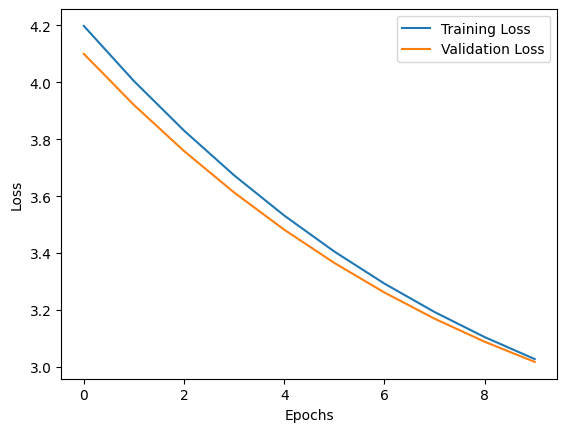

In [29]:
train(model=bigram, train_loader=bigram_train_loader, validation_loader=bigram_validation_loader)

Epoch 1/10: 100%|██████████| 436/436 [00:21<00:00, 20.64it/s]


Training Loss: 3.5756569630509123
Validation Loss: 3.089278304248775


Epoch 2/10: 100%|██████████| 436/436 [00:21<00:00, 20.32it/s]


Training Loss: 2.9052412766929065
Validation Loss: 2.7995630010552364


Epoch 3/10: 100%|██████████| 436/436 [00:21<00:00, 20.22it/s]


Training Loss: 2.700560010354453
Validation Loss: 2.65087714982689


Epoch 4/10: 100%|██████████| 436/436 [00:21<00:00, 20.11it/s]


Training Loss: 2.586533133589893
Validation Loss: 2.5576052971936147


Epoch 5/10: 100%|██████████| 436/436 [00:21<00:00, 20.49it/s]


Training Loss: 2.5091456420924687
Validation Loss: 2.4851029903516855


Epoch 6/10: 100%|██████████| 436/436 [00:21<00:00, 20.16it/s]


Training Loss: 2.4431289625824046
Validation Loss: 2.4227150317725785


Epoch 7/10: 100%|██████████| 436/436 [00:21<00:00, 20.34it/s]


Training Loss: 2.383591123677175
Validation Loss: 2.368678773215058


Epoch 8/10: 100%|██████████| 436/436 [00:21<00:00, 20.42it/s]


Training Loss: 2.332583759902814
Validation Loss: 2.3221422794762008


Epoch 9/10: 100%|██████████| 436/436 [00:21<00:00, 20.35it/s]


Training Loss: 2.2885003532838386
Validation Loss: 2.2808492992996077


Epoch 10/10: 100%|██████████| 436/436 [00:21<00:00, 20.46it/s]


Training Loss: 2.245427009162553
Validation Loss: 2.2364355599114654


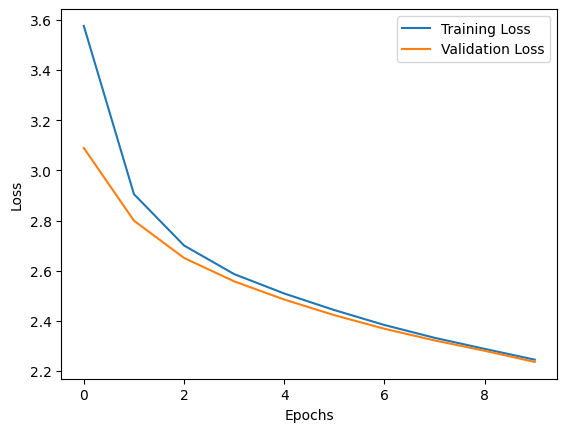

In [30]:
train(model=transformer, train_loader=train_loader, validation_loader=validation_loader)

# Inference

In [31]:
prompt = "To be or not to be"
bigram.generate(prompt, max_new_tokens=100)

vaRUgUGz;
B$Scamju t IbeVindt,thgytheaYrI?jTu
THyorhXjue blfbWEA
 er

In [32]:
prompt = "To be or not to be"
transformer.generate(prompt)

r my dioustt
Tharous rand, avigur hily ondig haye,
Whist sow, dillurs my-se nord.
Sis, oper, noovam:
Venor the yor,
Tho 'me four memy whow: lith heack the ton fongtce.

WANG YMETo oo therdrte, I thed tereand bath'd vererm
An to his ron wrwin bu tomamsts aleng dugend,
Ther un shey ly me ucas, crast,
Ut mjoulous, mangmat me dee haits eays mont fe wow
Re maug noin math't mousp mord swens
Asre at lite frath prourter ime leat.

ARDUSMOLIUCULOF my dicereastin.
E:

Falll song was; perering to an.

Yato Jitik,
HARIBRD
BUCOUD:
I nomy poughot deack hiy yof angents,
Ane
And bund I alt thoe lis yolf muar bucnchard
Hirs lop mow bed tout ick wiRir sof ronche;
As grot wbrecelitat kiour eng aver.
Goud baverootisst;
HYoaks an an a froke ged
Sioll I:
Ththon er roomabemb bror the thagaze dum, ve, in'cand hamber ve deneaig feder't
An, I
TIIe gors nof wrown But.

Cerute her RIUSTHet am?
ANC
BEONTEUS:
Go yohe, wharve now, crimy hur is ined! sou bair!
Lie:
Hay mallve crat fand